In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [21]:
n = 100
m = 100
batch_size = 32


In [22]:
w1 = tf.Variable(tf.initializers.GlorotNormal()((n, 1)), name='w1')
b1 = tf.Variable(tf.initializers.GlorotNormal()((n, 1)), name='b1')
w2 = tf.Variable(tf.initializers.GlorotNormal()((n, n)), name='w2')
b2 = tf.Variable(tf.initializers.GlorotNormal()((n, 1)), name='b2')
w3 = tf.Variable(tf.initializers.GlorotNormal()((1, n)), name='w3')


In [23]:
test_constant = tf.constant(np.random.rand(1, m), dtype = tf.float32)


In [24]:
alpha = tf.constant(10.0)
dx = tf.constant(0.001)
lr = tf.constant(0.0001)

In [25]:
def f(x):
    output = w1 @ x + b1
    output = tf.sin(output)
    output = w2 @ output + b2
    output = tf.sin(output)
    output =  w3 @output 
    return output

In [26]:
print(f(test_constant).shape)

(1, 100)


In [27]:
def d_dx(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        ddx = tape.gradient(f(x), x)
    return ddx

In [28]:
a = d_dx(test_constant)
print(a.shape)

(1, 100)


In [29]:
def d2_dx2(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        d2dx2 = tape.gradient(d_dx(x), x)
    return d2dx2

In [30]:
print(d2_dx2(test_constant).shape)

(1, 100)


In [31]:
# ODE loss function
def ode_loss(x):
    diff_loss = tf.reduce_mean(tf.square(d2_dx2(x) +  f(x)))
    ic1 = tf.reduce_mean(tf.square(d_dx(tf.zeros((1, m), dtype=tf.float32))))
    ic2 = tf.reduce_mean(tf.square(f(tf.zeros((1, m), dtype=tf.float32)) - tf.constant(1.0)))
    return diff_loss + ic1 + ic2

In [32]:
x_batch = tf.constant(np.random.rand(1, m)*5, dtype=tf.float32)
loss = ode_loss(x_batch)
print(loss)

tf.Tensor(1.4761415, shape=(), dtype=float32)


In [36]:
# Training loop
loss_history = []
epochs = 500
optimizer = tf.optimizers.Adam(learning_rate=lr)

for epoch in range(epochs):
    # Generate a batch of random inputs
    x_batch = tf.constant(np.random.rand(1, m)*5, dtype=tf.float32)
    
    # Compute loss and gradients
    with tf.GradientTape() as tape:
        loss = ode_loss(x_batch)
        grads = tape.gradient(loss, [w1, b1, w2, b2, w3])
    
        # Apply gradients
        optimizer.apply_gradients(zip(grads, [w1, b1, w2, b2, w3]))
    
    # Record loss
    loss_history.append(loss.numpy())
    
    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

Epoch 0, Loss: 0.03162376955151558
Epoch 100, Loss: 0.011418942362070084
Epoch 200, Loss: 0.008862468414008617
Epoch 300, Loss: 0.006864643190056086
Epoch 400, Loss: 0.006186440587043762


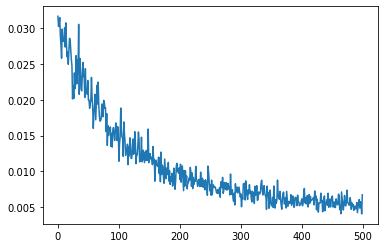

In [37]:
#Plot loss
plt.plot(loss_history)

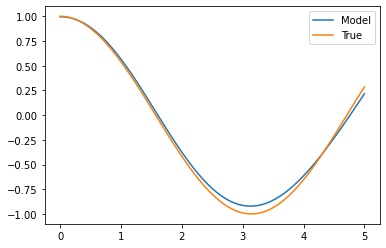

In [38]:
#Plot model
x = np.linspace(0, 5, m).reshape(1,m)
x = tf.constant(x, dtype = tf.float32)
x.shape
plt.plot(x.numpy().flatten(), f(x).numpy().flatten(), label = "Model")
plt.plot(x.numpy().flatten(), np.cos(x*1).flatten(), label = "True")
plt.legend()
